In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, norm
import random
random.seed(80)

# Part 1 : Bayesian estimation

In [27]:
# Load updated dataset
cleaned_data = pd.read_csv("Airplane_crashes_cleaned.csv")

In [28]:
# Select relevant columns and rename them with English names
filtered_data = cleaned_data[['Date', 'Total_Décès']].rename(columns={'Date': 'DATE', 'Total_Décès': 'Total_death'})

In [29]:
filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'], errors='coerce')

In [30]:
# Convert the date column to datetime format and extract temporal information
filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'], format='%d/%m/%y', errors='coerce')  # Ensure proper date parsing
filtered_data['WEEK'] = filtered_data['DATE'].dt.isocalendar().week  # Extract the week of the year
filtered_data['MONTH'] = filtered_data['DATE'].dt.month  # Extract the month
filtered_data['YEAR'] = filtered_data['DATE'].dt.year  # Extract the year
filtered_data = filtered_data[(filtered_data['YEAR'] >= 2010) & (filtered_data['YEAR'] <= 2012)]


In [31]:
# Calculate the number of incidents per month and per week
monthly_counts = []
for year in range(min(filtered_data['YEAR']),max(filtered_data['YEAR'])+1):
    month_data = [filtered_data[(filtered_data['MONTH'] == month) & (filtered_data['YEAR'] == year)].shape[0] 
                  for month in range(1, 13)]  # Count incidents for each month of the year
    monthly_counts.append(month_data)
monthly_counts = np.array(monthly_counts)  # Convert to NumPy array for further processing

weekly_counts = []
for year in range(min(filtered_data['YEAR']),max(filtered_data['YEAR'])+1):
    week_data = [filtered_data[(filtered_data['WEEK'] == week) & (filtered_data['YEAR'] == year)].shape[0] 
                 for week in range(1, 54)]  # Count incidents for each week of the year
    weekly_counts.append(week_data)
weekly_counts = np.array(weekly_counts)  # Convert to NumPy array for further processing


In [32]:
# Bayesian estimator with uniform prior
weekly_data_flat = weekly_counts.flatten()  # Flatten the weekly counts array 
monthly_data_flat = monthly_counts.flatten()  # Flatten the monthly counts array

# Define a uniform prior
uniform_prior = np.full(100, 1 / 100)  # Uniform probability across 100 points
prior_values = np.linspace(0, max(weekly_data_flat), 100)  # Range of prior values based on max weekly data


In [33]:
# Function to compute the posterior distribution
def compute_posterior(likelihood_func, prior, observations):
    """
    Calculate the posterior distribution given a likelihood function, prior, and data.

    Args:
        likelihood_func: Function to compute the likelihood (e.g., Poisson PMF).
        prior: Array representing the prior distribution.
        observations: Array of observed data.

    Returns:
        Array representing the posterior distribution.
    """
    # Compute the likelihood for each observation
    likelihood = np.array([likelihood_func(obs, prior_values) for obs in observations]).prod(axis=0)
    # Compute the posterior by combining prior and likelihood
    posterior = likelihood * prior
    # Normalize the posterior to ensure it sums to 1
    posterior /= posterior.sum()
    return posterior

# Compute posterior distributions for weekly and monthly data
weekly_posterior = compute_posterior(poisson.pmf, uniform_prior, weekly_data_flat)
monthly_posterior = compute_posterior(poisson.pmf, uniform_prior, monthly_data_flat)


In [34]:
# Bayesian estimator with Gamma prior
alpha_param = 102  # Shape parameter for the Gamma prior
beta_week = 1 / 159  # Scale parameter for weekly data
beta_month = 1 / 36  # Scale parameter for monthly data

# Compute posterior mean for weekly data
weekly_posterior_gamma = (weekly_data_flat.sum() + alpha_param) / (len(weekly_data_flat) + 1 / beta_week)

# Compute posterior mean for monthly data
monthly_posterior_gamma = (monthly_data_flat.sum() + alpha_param) / (len(monthly_data_flat) + 1 / beta_month)

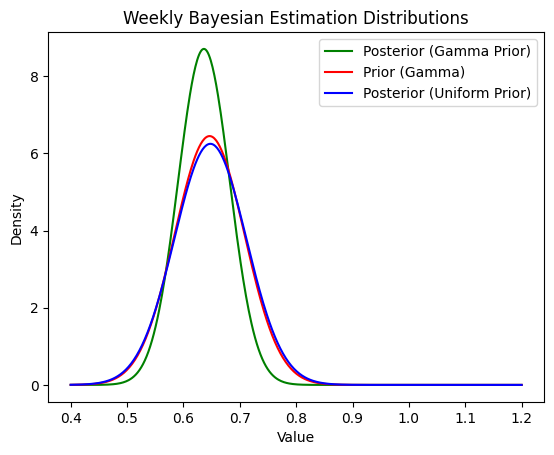

In [35]:

# Weekly plots (Posterior and Prior distributions)
# Compute summary statistics for the posterior with uniform prior
posterior_uniform_mean_weekly = np.dot(weekly_posterior, prior_values)
posterior_uniform_sd_weekly = np.sqrt(np.dot(weekly_posterior, (prior_values - posterior_uniform_mean_weekly) ** 2))

# Posterior Gamma distribution for weekly data
gamma_posterior_weekly = gamma.rvs(a=2 * alpha_param, scale=1 / (2 * 159), size=159)
x_posterior_gamma_weekly = np.linspace(0.4, 1.2, 500)
y_posterior_gamma_weekly = norm.pdf(x_posterior_gamma_weekly, loc=np.mean(gamma_posterior_weekly), scale=np.std(gamma_posterior_weekly))
plt.plot(x_posterior_gamma_weekly, y_posterior_gamma_weekly, label="Posterior (Gamma Prior)", color="green")


# Prior Gamma distribution for weekly data
gamma_prior_weekly = gamma.rvs(a=alpha_param, scale=beta_week, size=159)
x_prior_gamma_weekly = np.linspace(0.4, 1.2, 500)
y_prior_gamma_weekly = norm.pdf(x_prior_gamma_weekly, loc=np.mean(gamma_prior_weekly), scale=np.std(gamma_prior_weekly))
plt.plot(x_prior_gamma_weekly, y_prior_gamma_weekly, label="Prior (Gamma)", color="red")


# Define the range for the posterior uniform distribution plot
x_uniform_weekly = np.linspace(0.4, 1.2, 500)
y_uniform_weekly = norm.pdf(x_uniform_weekly, loc=posterior_uniform_mean_weekly, scale=posterior_uniform_sd_weekly)
plt.plot(x_uniform_weekly, y_uniform_weekly, label="Posterior (Uniform Prior)", color="blue")

# Add legend and display the plot
plt.legend()
plt.title("Weekly Bayesian Estimation Distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


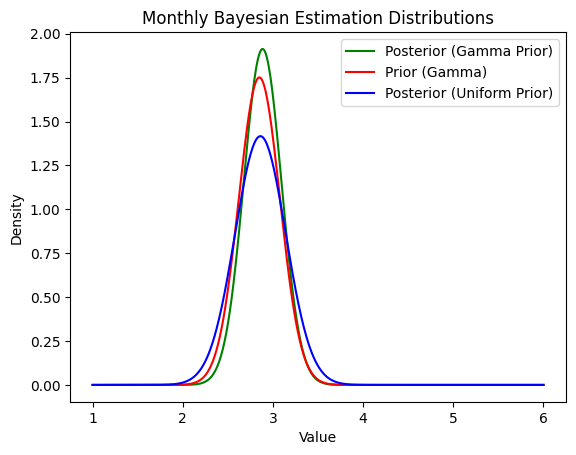

In [36]:
# Monthly plots (Posterior and Prior distributions)
# Compute summary statistics for the posterior with uniform prior
posterior_uniform_mean_monthly = np.dot(monthly_posterior, prior_values)
posterior_uniform_sd_monthly = np.sqrt(np.dot(monthly_posterior, (prior_values - posterior_uniform_mean_monthly) ** 2))

# Posterior Gamma distribution for monthly data
gamma_posterior_monthly = gamma.rvs(a=2*alpha_param, scale=1/(2*36), size=36)
x_posterior_gamma_monthly = np.linspace(1, 6, 500)
y_posterior_gamma_monthly = norm.pdf(x_posterior_gamma_monthly, loc=np.mean(gamma_posterior_monthly), scale=np.std(gamma_posterior_monthly))
plt.plot(x_posterior_gamma_monthly, y_posterior_gamma_monthly, label="Posterior (Gamma Prior)", color="green")


# Prior Gamma distribution for monthly data
gamma_prior_monthly = gamma.rvs(a=alpha_param, scale=beta_month, size=36) 
x_prior_gamma_monthly = np.linspace(1, 6, 500)
y_prior_gamma_monthly = norm.pdf(x_prior_gamma_monthly, loc=np.mean(gamma_prior_monthly), scale=np.std(gamma_prior_monthly))
plt.plot(x_prior_gamma_monthly, y_prior_gamma_monthly, label="Prior (Gamma)", color="red")

# Define the range for the posterior uniform distribution plot
x_uniform_monthly = np.linspace(1, 6, 500)
y_uniform_monthly = norm.pdf(x_uniform_monthly, loc=posterior_uniform_mean_monthly, scale=posterior_uniform_sd_monthly)
plt.plot(x_uniform_monthly, y_uniform_monthly, label="Posterior (Uniform Prior)", color="blue")


# Add legend and display the plot
plt.legend()
plt.title("Monthly Bayesian Estimation Distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [37]:
def rmse(x, t):
    """
    Compute the Root Mean Squared Error (RMSE) between two arrays.
    """
    return np.sqrt(np.mean((np.array(x) - np.array(t)) ** 2))

### Biais for week

In [38]:
# Bootstrap samples for weekly data
# Maximum likelihood estimate (MLE) for weekly data
mle_weekly = weekly_data_flat.sum() / len(weekly_data_flat)
bootstrap_samples_weekly = np.random.poisson(mle_weekly, (500, len(weekly_data_flat)))

In [39]:
# Bayesian estimator with uniform prior for bootstrap samples
def bayesian_estimator_uniform(data):
    """
    Computes the Bayesian estimate for data using a uniform prior.
    """
    posterior_distribution = compute_posterior(poisson.pmf, uniform_prior, data)
    return np.dot(posterior_distribution, prior_values)

# Apply the uniform Bayesian estimator across bootstrap samples
bootstrap_estimates_uniform = np.apply_along_axis(bayesian_estimator_uniform, 1, bootstrap_samples_weekly)
bias_uniform_weekly = bootstrap_estimates_uniform.mean() - posterior_uniform_mean_weekly

rmse_unif_weekly = rmse(bootstrap_estimates_uniform, weekly_posterior.mean())


In [40]:
# Bayesian estimator with Gamma prior for bootstrap samples
def bayesian_estimator_gamma(data, alpha_param, beta_param):
    """
    Computes the Bayesian estimate for data using a Gamma prior.
    """
    return (data.sum() + alpha_param) / (len(data) + 1 / beta_param)

# Apply the Gamma Bayesian estimator across bootstrap samples
bootstrap_estimates_gamma = np.apply_along_axis(bayesian_estimator_gamma, 1, bootstrap_samples_weekly, alpha_param, beta_week)
bias_gamma_weekly = bootstrap_estimates_gamma.mean() - weekly_posterior_gamma

rmse_gamma_weekly = rmse(bootstrap_samples_weekly,weekly_posterior_gamma)


# Print biases for uniform and gamma priors
print(f"Bias for Uniform Prior (weekly): {bias_uniform_weekly}")
print(f"Bias for Gamma Prior (weekly): {bias_gamma_weekly}")

# Print rmse for uniform and gamma priors
print(f"RMSE for Uniform Prior (weekly): {rmse_unif_weekly}")
print(f"RMSE for Gamma Prior (weekly): {rmse_gamma_weekly}")

Bias for Uniform Prior (weekly): 8.805031443670508e-05
Bias for Gamma Prior (weekly): 4.402515723278544e-05
RMSE for Uniform Prior (weekly): 0.6408697507445488
RMSE for Gamma Prior (weekly): 0.7968099742360951


### Same for Month

In [41]:
# Bootstrap samples for monthly data
# Maximum likelihood estimate (MLE) for monthly data
mle_monthly = monthly_data_flat.sum() / len(monthly_data_flat)
bootstrap_samples_monthly = np.random.poisson(mle_monthly, (500, len(monthly_data_flat)))

In [42]:
# Bayesian estimator with uniform prior for bootstrap samples
def bayesian_estimator_uniform(data):
    """
    Computes the Bayesian estimate for data using a uniform prior.
    """
    posterior_distribution = compute_posterior(poisson.pmf, uniform_prior, data)
    return np.dot(posterior_distribution, prior_values)

# Apply the uniform Bayesian estimator across bootstrap samples
bootstrap_estimates_uniform = np.apply_along_axis(bayesian_estimator_uniform, 1, bootstrap_samples_monthly)
bias_uniform_monthly = bootstrap_estimates_uniform.mean() - posterior_uniform_mean_monthly

rmse_unif_monthly = rmse(bootstrap_estimates_uniform, monthly_posterior.mean())


In [43]:
# Bayesian estimator with Gamma prior for bootstrap samples
def bayesian_estimator_gamma(data, alpha_param, beta_param):
    """
    Computes the Bayesian estimate for data using a Gamma prior.
    """
    return (data.sum() + alpha_param) / (len(data) + 1 / beta_param)

# Apply the Gamma Bayesian estimator across bootstrap samples
bootstrap_estimates_gamma = np.apply_along_axis(bayesian_estimator_gamma, 1, bootstrap_samples_monthly, alpha_param, beta_week)
bias_gamma_monthly = bootstrap_estimates_gamma.mean() - monthly_posterior_gamma

rmse_gamma_monthly = rmse(bootstrap_estimates_gamma, monthly_posterior_gamma.mean())

# Print biases for uniform and gamma priors
print(f"Bias for Uniform Prior (monthly): {bias_uniform_monthly}")
print(f"Bias for Gamma Prior (monthly): {bias_gamma_monthly}")

# Print biases for uniform and gamma priors
print(f"RMSE for Uniform Prior (monthly): {rmse_unif_monthly}")
print(f"RMSE for Gamma Prior (monthly): {rmse_gamma_monthly}")

Bias for Uniform Prior (monthly): 0.008310760712093579
Bias for Gamma Prior (monthly): -1.785169230769231
RMSE for Uniform Prior (monthly): 2.8717721954968716
RMSE for Gamma Prior (monthly): 1.7858796730023918


# PART 2 : Hierarchical Structure by Airline Companies

In [44]:
data = pd.read_csv("Airplane_crashes_cleaned.csv")

In [45]:
data 

,Date,Heures,Localisation,Compagnie,Route,Type,Total_ABord,Passagers_ABord,Crew_ABord,Total_Décès,...,Crew_D�c�s,Au_sol,R�sum�,Ann�e,Mois,Jours,D�cennie,Heure,Minute,Pays_Etat
0,1908-09-17,17H 18M 0S,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2,1,1,1,...,0,0,"During a demonstration flight, a U.S. Army fly...",1908,9,17,1900,17.0,18.0,Virginia
1,1909-09-07,NaN,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1,0,1,1,...,0,0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7,1900,NaN,NaN,France
2,1912-07-12,6H 30M 0S,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5,0,5,5,...,5,0,First U.S. dirigible Akron exploded just offsh...,1912,7,12,1910,6.0,30.0,New Jersey
3,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1,0,1,1,...,1,0,The first fatal airplane accident in Canada oc...,1913,8,6,1910,NaN,NaN,Canada
4,1913-09-09,18H 30M 0S,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20,0,0,14,...,0,0,The airship flew into a thunderstorm and encou...,1913,9,9,1910,18.0,30.0,Over the North Sea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2019-04-16,11H 0M 0S,"Puerto Montt, Chile",Archipelagos Service Aereos,Puerto Montt - Ayacara,Pilatus-Britten Norman BN-2B-27 Islander,6,5,1,6,...,1,0,"While the aircraft was in the initial climb, p...",2019,4,16,2010,11.0,0.0,Chile
4963,2019-05-05,18H 30M 0S,"Monclava, Mexico",TVPX Aircraft Solutions,Las Vegas - Monterrey,Canadair CL-600-2B16-Challenger,13,11,2,13,...,2,0,The aircraft crashed while en route on a retur...,2019,5,5,2010,18.0,30.0,Mexico
4964,2019-05-05,18H 30M 0S,"Moscow, Russia",Aeroflot Russian International Airlines,Moscow - Murmansk,Sukhoi Superjet-100-95B,78,73,5,41,...,1,0,Forty-five minutes after taking off from Mosco...,2019,5,5,2010,18.0,30.0,Russia
4965,2019-06-03,13H 0M 0S,"Lipo, India",Military - Indian Air Force,Jorhat-Rowriah - Mechuka,Antonov An-32,13,5,8,13,...,8,0,Crashed about 34km WNW of Mechuka.,2019,6,3,2010,13.0,0.0,India


In [46]:
data = pd.read_csv('Airplane_crashes_cleaned.csv')

# Convertir la colonne 'Année' en entier pour l'agrégation
data['Année'] = pd.to_numeric(data['Ann�e'], errors='coerce')

# Filtrer uniquement les colonnes nécessaires : 'Année' et 'Compagnie'
filtered_data = data[['Année', 'Compagnie']].dropna()

# Ajouter une colonne pour grouper les années par tranche de 5 ans
filtered_data['Période_5_ans'] = (filtered_data['Année'] // 5) * 5

# Créer une table croisée avec les périodes de 5 ans en lignes et les compagnies en colonnes
crash_count_by_company = pd.pivot_table(
    filtered_data,
    index='Période_5_ans',
    columns='Compagnie',
    aggfunc='size',  # Compter le nombre d'occurrences (crashs)
    fill_value=0  # Remplacer les valeurs manquantes par 0
)

total_crashes_by_company = crash_count_by_company.sum(axis=0)

# Trier les compagnies par nombre total de crashs décroissant
sorted_crash_count = crash_count_by_company[total_crashes_by_company.sort_values(ascending=False).index]

# Afficher les premières lignes de la base triée

In [47]:
sorted_crash_count

Compagnie,Aeroflot,Military - U.S. Air Force,Air France,Deutsche Lufthansa,United Air Lines,China National Aviation Corporation,Military - U.S. Army Air Forces,Pan American World Airways,American Airlines,US Aerial Mail Service,...,Franco-Roumaine,Fragtflug,Ford Air Freight Inc.,Force Area Populaire de Angola,Fokker,Flyve Tjenesten,Flying W Airways,Flydubai,Fly Montserrat,�koda (India) Ltd
Période_5_ans,,,,,,,,,,,,,,,,,,,,,
1905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
1920,0,0,0,0,0,0,0,0,0,27,...,1,0,0,0,0,0,0,0,0,0
1925,0,0,0,12,0,0,0,0,0,3,...,0,0,1,0,1,0,0,0,0,0
1930,1,0,7,11,2,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1935,2,0,15,22,7,5,0,3,3,0,...,0,0,0,0,0,0,0,0,0,0
1940,5,3,6,17,3,18,21,5,4,0,...,0,0,0,0,0,0,0,0,0,0
1945,15,8,12,1,6,15,22,6,8,0,...,0,0,0,0,0,0,0,0,0,0


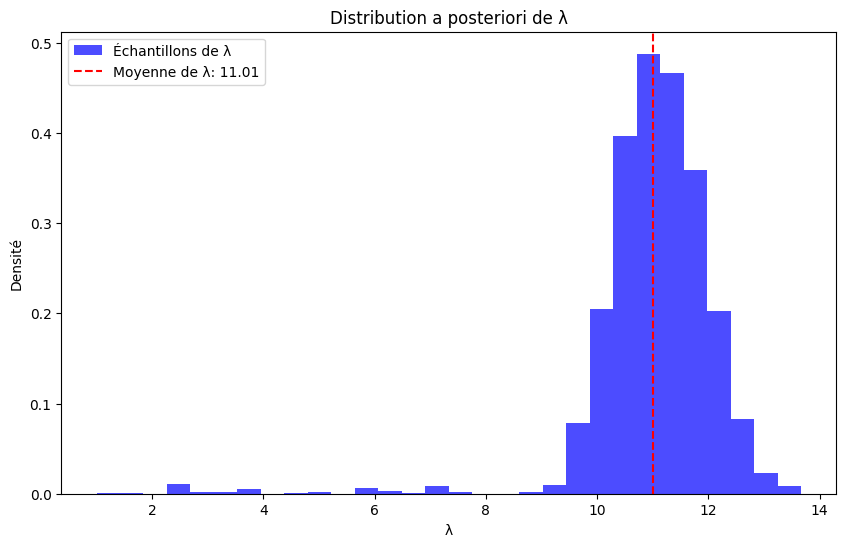

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Exemple de données : Nombre de crashs par tranche de 5 ans
# Remplacez 'sorted_crash_count.iloc[:, 0]' par les crashs réels de votre dataset
crashes_per_5_years = np.array(sorted_crash_count.iloc[:, 0])

# Définition du prior Log-Normal sur lambda
mu_prior = 0  # Moyenne du prior log-normal
sigma_prior = 10  # Ecart-type du prior log-normal

# Fonction de vraisemblance : Poisson
def poisson_log_likelihood(data, lam):
    return np.sum(stats.poisson.logpmf(data, lam))

# Fonction pour échantillonner via Metropolis-Hastings
def metropolis_hastings(data, prior_mu, prior_sigma, n_samples, initial_lambda, proposal_width=0.5):
    lambda_samples = np.zeros(n_samples)
    lambda_samples[0] = initial_lambda
    
    # Calcul de la vraisemblance initiale
    current_lambda = initial_lambda
    current_log_likelihood = poisson_log_likelihood(data, current_lambda) + np.sum(stats.lognorm.logpdf(current_lambda, prior_sigma, scale=np.exp(prior_mu)))
    
    for i in range(1, n_samples):
        # Proposer une nouvelle valeur pour lambda
        proposed_lambda = np.random.normal(current_lambda, proposal_width)
        
        # Calcul de la vraisemblance pour la nouvelle valeur proposée
        proposed_log_likelihood = poisson_log_likelihood(data, proposed_lambda) + np.sum(stats.lognorm.logpdf(proposed_lambda, prior_sigma, scale=np.exp(prior_mu)))
        
        # Calcul du ratio d'acceptation
        acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)
        
        # Accepter ou rejeter la proposition
        if np.random.rand() < acceptance_ratio:
            current_lambda = proposed_lambda
            current_log_likelihood = proposed_log_likelihood
        
        lambda_samples[i] = current_lambda
    
    return lambda_samples

# Nombre d'échantillons à générer
n_samples = 2000

# Lambda initial (peut être une valeur arbitraire, ici 1)
initial_lambda = 1

# Échantillonnage via Metropolis-Hastings
lambda_samples = metropolis_hastings(crashes_per_5_years, mu_prior, sigma_prior, n_samples, initial_lambda)

# Calcul de la moyenne des échantillons de λ
lambda_mean = np.mean(lambda_samples)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.hist(lambda_samples, bins=30, density=True, alpha=0.7, color='blue', label='Échantillons de λ')
plt.axvline(lambda_mean, color='red', linestyle='--', label=f'Moyenne de λ: {lambda_mean:.2f}')
plt.xlabel('λ')
plt.ylabel('Densité')
plt.title('Distribution a posteriori de λ')
plt.legend()
plt.show()


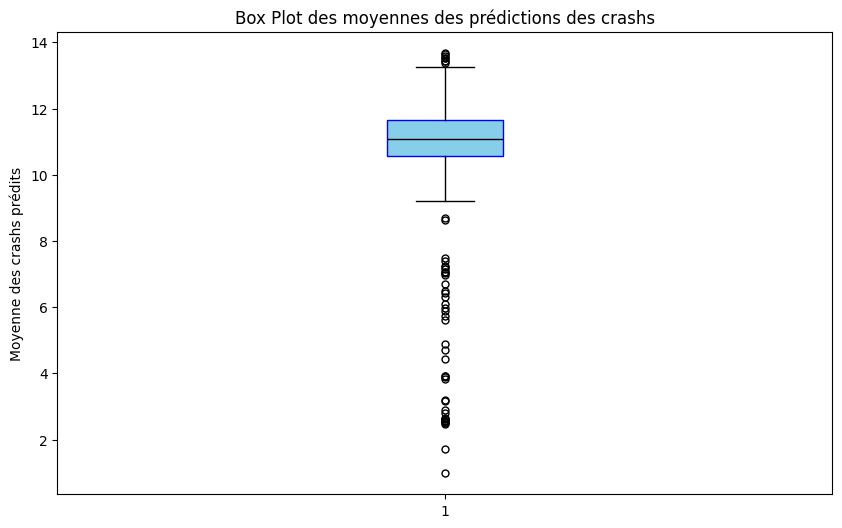

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Supposons que lambda_samples sont les échantillons que tu as obtenus de MCMC
# Nombre de nouvelles périodes pour lesquelles faire des prédictions
n_predictions = 1000  # Par exemple, simuler 1000 prédictions pour chaque lambda

# Échantillonner des nombres de crashs à partir de la loi de Poisson pour chaque lambda simulé
# Par exemple, pour chaque échantillon de lambda, nous allons prédire le nombre de crashs pour 5 ans
predicted_means = np.zeros(n_samples)  # Un tableau pour stocker les moyennes des prédictions pour chaque lambda

for i in range(n_samples):
    # Tirer 1000 échantillons à partir de la loi de Poisson avec le lambda_i de MCMC
    poisson_samples = stats.poisson.rvs(mu=lambda_samples[i], size=n_predictions)
    
    # Calculer la moyenne des crashs prédits pour ce lambda
    predicted_means[i] = np.mean(poisson_samples)

# Affichage du Box Plot vertical des moyennes des prédictions
plt.figure(figsize=(10, 6))
plt.boxplot(predicted_means, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"), 
            flierprops=dict(marker="o", color="red", markersize=5), medianprops=dict(color="black"))

# Ajouter un titre et des labels
plt.title('Box Plot des moyennes des prédictions des crashs')
plt.ylabel('Moyenne des crashs prédits')
plt.show()


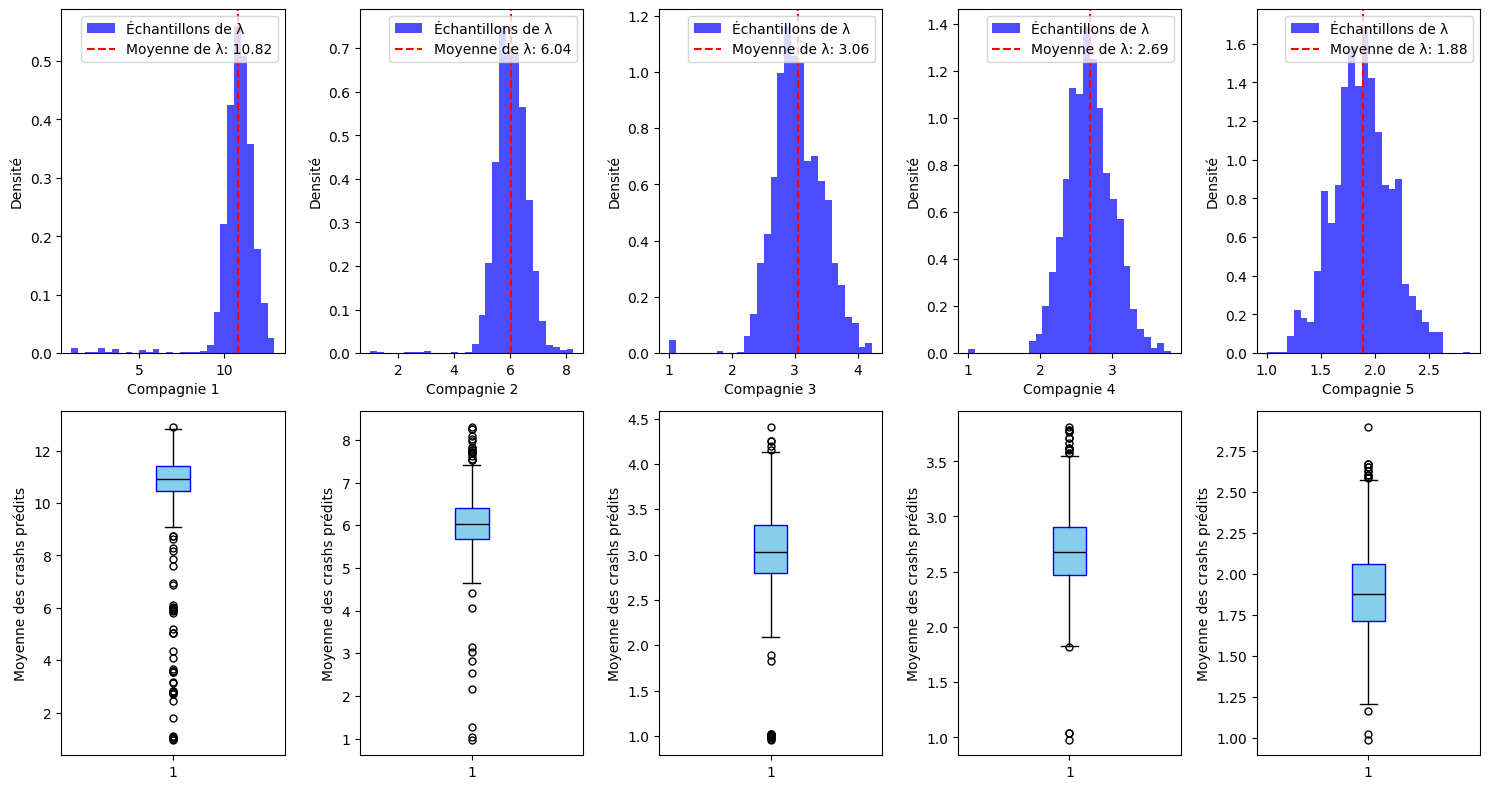

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Nombre d'échantillons à générer
n_samples = 2000

# Nombre de nouvelles périodes pour lesquelles faire des prédictions
n_predictions = 1000  # Par exemple, simuler 1000 prédictions pour chaque lambda

# Définition du prior Log-Normal sur lambda
mu_prior = 0  # Moyenne du prior log-normal
sigma_prior = 1  # Ecart-type du prior log-normal

# Fonction de vraisemblance : Poisson
def poisson_log_likelihood(data, lam):
    return np.sum(stats.poisson.logpmf(data, lam))

# Fonction pour échantillonner via Metropolis-Hastings
def metropolis_hastings(data, prior_mu, prior_sigma, n_samples, initial_lambda, proposal_width=0.5):
    lambda_samples = np.zeros(n_samples)
    lambda_samples[0] = initial_lambda
    
    # Calcul de la vraisemblance initiale
    current_lambda = initial_lambda
    current_log_likelihood = poisson_log_likelihood(data, current_lambda) + np.sum(stats.lognorm.logpdf(current_lambda, prior_sigma, scale=np.exp(prior_mu)))
    
    for i in range(1, n_samples):
        # Proposer une nouvelle valeur pour lambda
        proposed_lambda = np.random.normal(current_lambda, proposal_width)
        
        # Calcul de la vraisemblance pour la nouvelle valeur proposée
        proposed_log_likelihood = poisson_log_likelihood(data, proposed_lambda) + np.sum(stats.lognorm.logpdf(proposed_lambda, prior_sigma, scale=np.exp(prior_mu)))
        
        # Calcul du ratio d'acceptation
        acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)
        
        # Accepter ou rejeter la proposition
        if np.random.rand() < acceptance_ratio:
            current_lambda = proposed_lambda
            current_log_likelihood = proposed_log_likelihood
        
        lambda_samples[i] = current_lambda
    
    return lambda_samples

# Initialisation de la figure pour les sous-graphes
fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# Itération sur les 5 premières colonnes de sorted_crash_count
for i in range(5):
    # Extrait les crashs pour chaque compagnie
    crashes_per_5_years = np.array(sorted_crash_count.iloc[:, i])
    
    # Lambda initial (peut être une valeur arbitraire, ici 1)
    initial_lambda = 1
    
    # Échantillonnage via Metropolis-Hastings
    lambda_samples = metropolis_hastings(crashes_per_5_years, mu_prior, sigma_prior, n_samples, initial_lambda)
    
    # Calcul de la moyenne des échantillons de λ
    lambda_mean = np.mean(lambda_samples)
    
    # Prédictions : échantillonner des nombres de crashs à partir de la loi de Poisson pour chaque lambda simulé
    predicted_means = np.zeros(n_samples)
    for j in range(n_samples):
        poisson_samples = stats.poisson.rvs(mu=lambda_samples[j], size=n_predictions)
        predicted_means[j] = np.mean(poisson_samples)
    
    # Histogramme des échantillons de lambda
    axs[0, i].hist(lambda_samples, bins=30, density=True, alpha=0.7, color='blue', label='Échantillons de λ')
    axs[0, i].axvline(lambda_mean, color='red', linestyle='--', label=f'Moyenne de λ: {lambda_mean:.2f}')
    axs[0, i].set_xlabel(f'Compagnie {i+1}')
    axs[0, i].set_ylabel('Densité')
    axs[0, i].legend()
    
    # Box plot des moyennes des prédictions
    axs[1, i].boxplot(predicted_means, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"), 
                       flierprops=dict(marker="o", color="red", markersize=5), medianprops=dict(color="black"))
    axs[1, i].set_ylabel('Moyenne des crashs prédits')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Sauvegarde l'image sous forme de fichier .png
plt.savefig("graphique_results.png")  # Le fichier sera enregistré dans le répertoire courant

# Affichage du graphique
plt.show()
